# Panel Regression with lag features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from linearmodels.panel import PanelOLS
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("data/full.csv")
oil_df = pd.read_csv("data/oil.csv")
promo_elasticity_df = pd.read_csv("data/promotion_elasticity.csv")
oil_elasticity_df = pd.read_csv("data/oil_elasticity.csv")
df["date"] = pd.to_datetime(df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])

In [3]:
df = df.merge(oil_df, on="date", how="left")
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")

In [4]:
df["lag_1m"] = df.groupby(["store_nbr", "family"])["sales"].shift(periods=31)
df["lag_1w"] = df.groupby(["store_nbr", "family"])["sales"].shift(periods=7)
df = df.dropna()

In [5]:
def get_train_test(df, date):
    df = df.copy()
    date = pd.to_datetime(date)
    train_df = df.loc[df["date"] < date]
    test_df = df.loc[df["date"] > date - pd.Timedelta("1 days")]
    train_df = train_df.set_index(["store_nbr", "date"])
    test_df = test_df.set_index(["store_nbr", "date"])
    
    return (train_df, test_df)

def train_panel_regression(train, test, features, target):
    X_train = train[features]
    X_train = pd.get_dummies(X_train)
    y_train = train[target]
    X_test = test[features]
    X_test = pd.get_dummies(X_test)
    y_test = test[target]
    
    panel_regression_model = PanelOLS(y_train, X_train, entity_effects=True, time_effects=True, check_rank=False, drop_absorbed=True)
    panel_model = panel_regression_model.fit()
    return (panel_model, panel_model.model.exog.vars)

def check_predictions(train, test, model, used_variables):
    family_prediction = pd.DataFrame()
    X_test = test.copy()
    X_test = pd.get_dummies(X_test)
    X_test = X_test[used_variables]
    average_sales = train.groupby("family")["sales"].mean()
    std_sales = train.groupby("family")["sales"].std()
    
    test["prediction"] = model.predict(X_test)
    test["mae"] = np.abs(test["sales"] - test["prediction"])
    
    family_prediction["avg_mae"] = test.groupby("family")["mae"].mean()
    family_prediction["pct_avg_sales"] = family_prediction["avg_mae"] / average_sales
    family_prediction["std_diff"] = family_prediction["avg_mae"] / std_sales
    family_prediction["worth_to_predict"] = family_prediction["std_diff"] < 1
    
    return (test, family_prediction)

def visualize_prediction(df, family, store_nbr):
    df = df.reset_index()
    fig, ax = plt.subplots(figsize=(15, 5))
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="sales", label='Real value', title=f'{family}({store_nbr}): Real / Predicted value')
    df[(df["family"] == family) & (df["store_nbr"] == store_nbr)].plot(ax=ax, x="date", y="prediction", label='Predicted value')
    ax.legend(['Real value', 'Predicted value'])
    plt.show()
    df[df["family"]==family].plot.scatter(x="sales", y="prediction")
    
def get_month_week_train_test(df):
    month_date = df.iloc[-1]["date"] - pd.Timedelta("31 days")
    train_month = df.loc[df.date <= month_date]
    test_month = df.loc[df.date > month_date]
    train_month = train_month.set_index(["store_nbr", "date"])
    test_month = test_month.set_index(["store_nbr", "date"])

    week_date = df.iloc[-1]["date"] - pd.Timedelta("7 days")
    train_week = df.loc[df.date <= week_date]
    test_week = df.loc[df.date > week_date]
    train_week = train_week.set_index(["store_nbr", "date"])
    test_week = test_week.set_index(["store_nbr", "date"])
    
    return (train_month, test_month, train_week, test_week)

In [6]:
train_month, test_month, train_week, test_week = get_month_week_train_test(df)

In [10]:
month_features = ['family', 'onpromotion', 'is_holiday', 'type', 'dcoilwtico', 'lag_1m']
week_features = ['family', 'onpromotion', 'is_holiday', 'type', 'dcoilwtico', 'lag_1m', 'lag_1w']
target = "sales"

In [11]:
panel_month, panel_month_variables = train_panel_regression(train_month, test_month, month_features, target)
panel_week, panel_week_variables = train_panel_regression(train_week, test_week, week_features, target)

/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24821/941073398.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, dcoilwtico, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  panel_model = panel_regression_model.fit()
/var/folders/14/8l60xyhn23vgqk95vx1p0rv00000gn/T/ipykernel_24821/941073398.py:20: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

is_holiday, dcoilwtico, family_SEAFOOD, type_A, type_B, type_C, type_D, type_E

  panel_model = panel_regression_model.fit()


In [16]:
month_predictions, month_family = check_predictions(train_month, test_month, panel_month, panel_month_variables)
week_predictions, week_family = check_predictions(train_week, test_week, panel_week, panel_week_variables)

In [20]:
month_family

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,5.691991,0.930077,0.915844,True
BABY CARE,4.177551,37.528543,6.057873,False
BEAUTY,5.361331,1.450645,1.125682,False
BEVERAGES,1152.986787,0.482536,0.499230,True
BOOKS,4.128608,56.423230,7.400757,False
BREAD/BAKERY,174.155086,0.374953,0.471589,True
CELEBRATION,8.472764,1.003446,0.527757,True
CLEANING,439.877142,0.410164,0.600706,True
DAIRY,315.817039,0.442286,0.467707,True


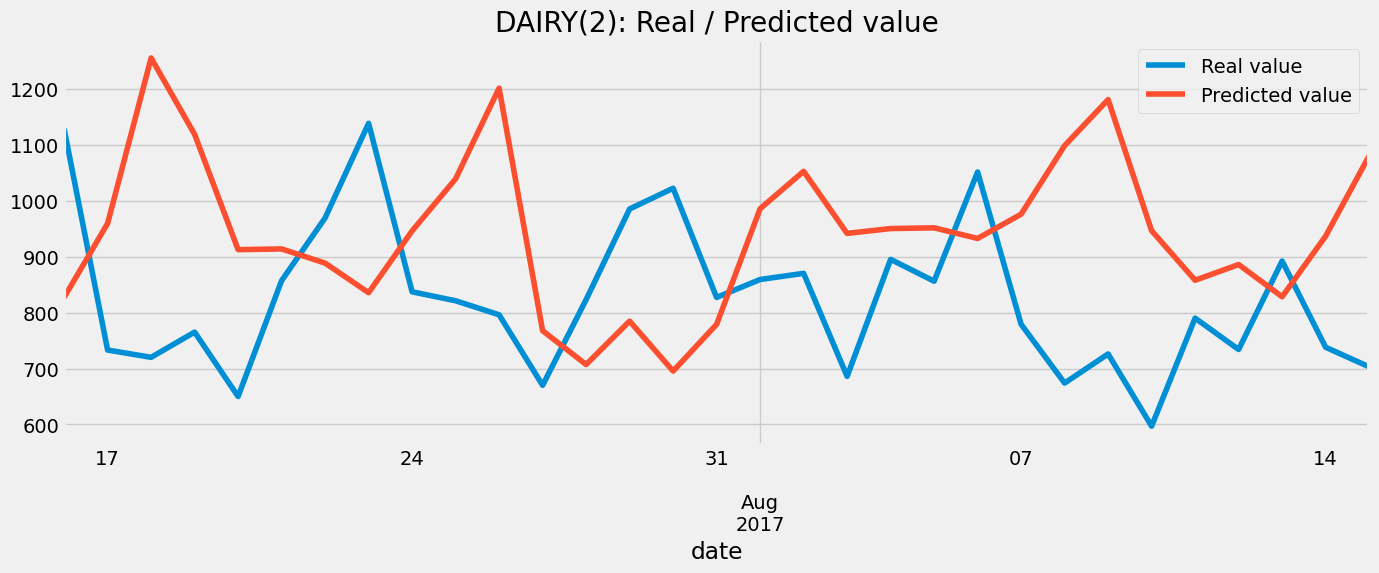

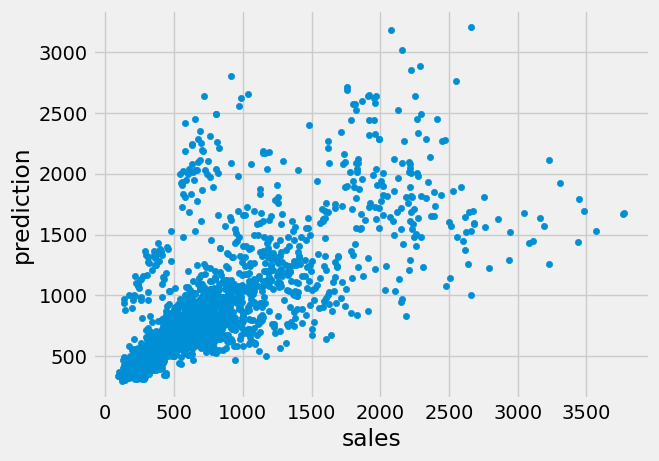

In [18]:
visualize_prediction(month_predictions, "DAIRY", 2)

In [21]:
week_family

,avg_mae,pct_avg_sales,std_diff,worth_to_predict
family,,,,
AUTOMOTIVE,3.521798,0.573650,0.567186,True
BABY CARE,0.829427,7.372282,1.205639,False
BEAUTY,3.161631,0.847920,0.658887,True
BEVERAGES,614.691995,0.255244,0.265201,True
BOOKS,0.773201,10.679901,1.395375,False
BREAD/BAKERY,94.659345,0.203287,0.256318,True
CELEBRATION,5.931592,0.697150,0.369573,True
CLEANING,325.588842,0.302439,0.442823,True
DAIRY,151.172599,0.211054,0.224049,True


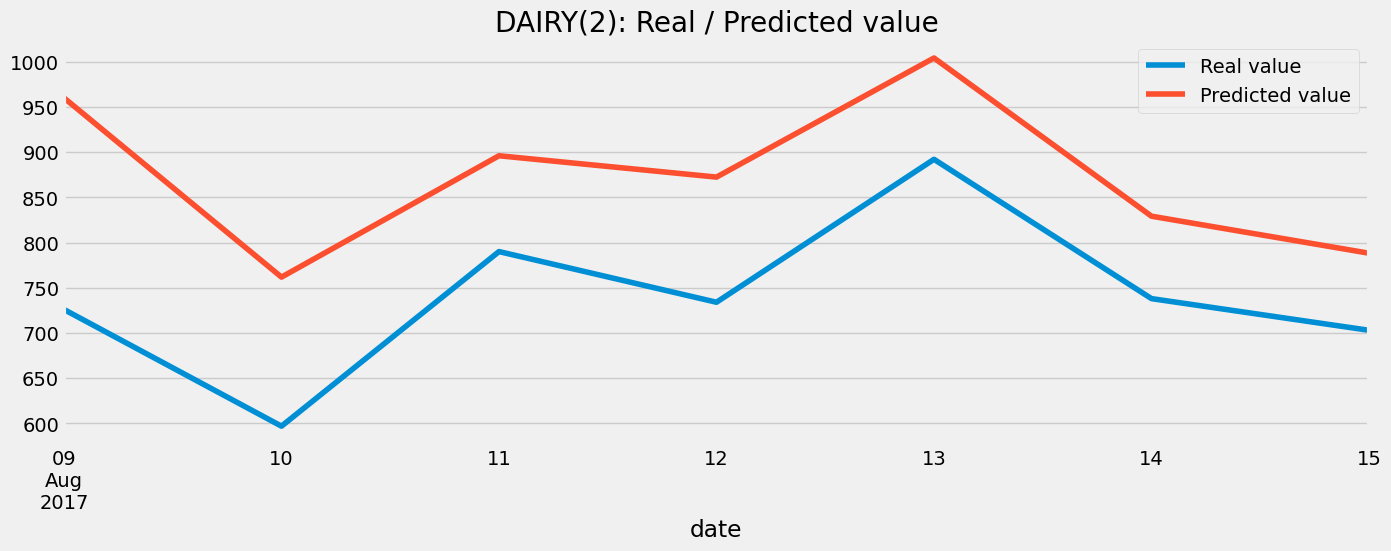

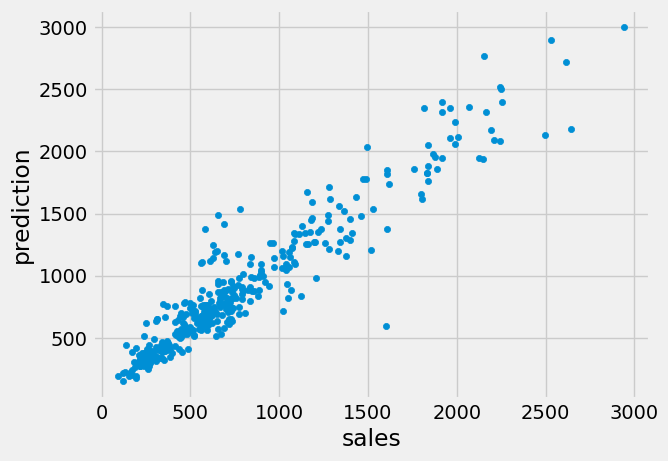

In [19]:
visualize_prediction(week_predictions, "DAIRY", 2)